# Bioinformatics Algorithms, Week 2

In Week 1, we attempted but did not succeed in finding finding the *ori* region in the genome of *E. coli* by looking for potential 9-mer *DnaA* box clumps. This week, we will try a different approach.

### More About DNA Replication

When it is time for DNA to be replicated, the complementary strands of DNA unravel, starting at *ori*. Replication begins when a short complementary segment called a **primer** anneals to a single-stranded section of the unraveling DNA and allows DNA polymerase to begin working. As the strands unwind and complementary strands begin construction, they form two **replication forks**. The replication forks travel along the bacterial chromosome until they meet at the **replication terminus** and the previously-together complementary strands separate completely. At this point, replication is complete and there are two semiconserved copies of the double-stranded chromosome.

Importantly, DNA polymerases can only traverse a single-stranded DNA in the 3' to 5' direction. This means that on the **reverse half-strand** (*ori* to *ter*, moving 3' to 5', **leading half-strand**), the DNA polymerase does not have to stop as long as the replication fork keeps widening. On the **forward half-strand** (*ter* to *ori*, moving 5' to 3', **lagging half-strand**), however, the DNA polymerase must transcribe short stretches called **Okazaki fragments** at a time, and wait for the replication fork to widen (~2000bp or so) so that a new primer can anneal upstream. In the diagram below, the forward (lagging) half-strand is thick and the reverse (leading) half-strand is thin.

<img src="http://bioinformaticsalgorithms.com/images/Replication/okazaki.png" width=400px />

Eventually, Okazaki fragments are sewn together by **DNA ligase** to form completely intact daughter chromosomes. 

#### G/C content in the half-strands
The nature of DNA replication means that the leading half-strand lives its life double-stranded a lot more than the lagging half-strand. This difference manifests at the molecular level in the G/C contents of the leading and lagging half-strands. Because cytosine readily undergoes methylation and deamination into thymine, and deamination rates rise 100-fold when a DNA is single-stranded, the lagging strand eventually accumulates a loss of cytosine. And, as the C-G base pairs are subsituted by T-A base pairs as a result, the leading strand, which is synthesized with the lagging strand as its template, accumulates a loss of guanine. 

<img src="http://bioinformaticsalgorithms.com/images/Replication/ecoli_frequency_difference.png" width=400px />

### The Skew Diagram and the Minimum Skew Problem

Exploiting these peculiar statistics, we can often infer the *ori* by plotting the relative G/C contents against the bin position in the genome. As we traverse the genome, we can keep track of the difference between G and C contents, and we can tell that, when the difference starts to increase, we are on the forward (lagging) half-strand; if the difference starts to decrease, we are on the reverse (leading) half-strand.

<img src="http://bioinformaticsalgorithms.com/images/Replication/increasing_decreasing_skew.png" width=400px />

We can artibrarily choose a position in the circular genome, and linearize it. Then, we can calculate the **skew** for the genome at any given position, and plot it on a diagram. Let's give it a shot.

In [1]:
def skew(pattern):
    values = {"A": 0, "C": -1, "G": 1, "T": 0}
    skews = [0] # always start at 0
    for i in pattern:
        skews.append(skews[-1] + values[i])
    return skews

In [2]:
f = open("E_coli.txt", "r")
E_coli_genome = f.read()
f.close()
skews = skew(E_coli_genome)

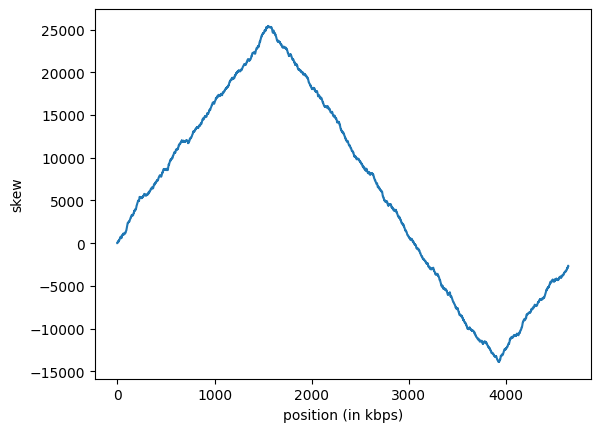

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# resampling to avoid having to plot a couple hundred thousand values
resampled_skews = skews[::1000]
x_positions = range(len(resampled_skews)) 

plt.plot(x_positions, resampled_skews)
plt.ylabel("skew")
plt.xlabel("position (in kbps)")
plt.show()

Nice! It looks like the *ter* is between 1000 and 2000 kbps, and the *ori* is just below 4000 kbps. But, to find the exact position of *ori*, we have to find the position of the minimum skew. 

**Minimum Skew Problem**: *Find a position in a genome where the skew diagram attains a minimum.*
- **Input**: A DNA string *Genome*.
- **Output**: All integer(s) *i* minimizing Skew<sub>i</sub> (*Genome*) among all values of *i* (from 0 to |*Genome*|).


In [4]:
def minimum_skew(genome):
    skews = skew(genome)
    minimum = min(skews)
    minimum_positions = [i for i in range(len(skews)) if skews[i] == minimum]
    return minimum_positions

In [5]:
print(minimum_skew(E_coli_genome))

[3923620, 3923621, 3923622, 3923623]


All right! Around 3923620 must be the *ori* in the *E. coli* genome. Let's take a look at a 500-nt window starting at this index, to see if we can find any promising contenders for *DnaA* boxes.

In [6]:
# Module 1 functions
def frequency_table(text, k):
    freq_map = {}
    for i in range(len(text)-k+1):
        pattern = text[i:i+k]

        if pattern not in freq_map:
            freq_map[pattern] = 1
        else:
            freq_map[pattern] += 1
    return freq_map
    
def better_frequent_words(text, k):
    
    def max_map(table): # Return the maximum value in a dictionary
        return max(table.values())
    
    frequent_patterns = []
    freq_map = frequency_table(text, k)
    max_val = max_map(freq_map)
    for pattern in freq_map.keys():
        if freq_map[pattern] == max_val:
            frequent_patterns.append(pattern)
    return frequent_patterns
    
potential_ori = E_coli_genome[3923620:3924120]
frequent = [key for key, value in frequency_table(potential_ori, 9).items() if value >= 3]
print(f'There are {len(frequent)} potential DnaA boxes')

There are 0 potential DnaA boxes


### The Frequent Words with Mismatches Problem
We still aren't able to find a *DnaA* box. However, we are dealing with real, physical, proteins and nucleic acids. A promoter sequence does not have to be totally exact—similar enough sequences will still allow a *DnaA* protein to bind to it. This means that we should **search for near-matches** as well as exact matches. 

**In other words, our existing solution to the **Frequent Words Problem** is inadequate. We will have to come up with another solution that allows for near-matches.**

To do this, we need to devise a few functions. The first is to quantify the difference between two strings of equal length—if two strings has two mismatches (e.g. CG**A**A**T** and CG**G**A**C**), then we say that their **Hamming distance** is 2. Hamming distance is one of many measures of [edit distance](https://en.wikipedia.org/wiki/Edit_distance), and a very basic one at that, but this is what we use.

In [7]:
def hamming_distance(s1, s2):
    diff = [i for i in range(len(s1)) if s1[i] != s2[i]]
    return len(diff)

OK, now we have a way of quantifying the difference between two strings. Let's try a variation of the **Pattern Matching Problem** from Week 1, now allowing for specified differences. 

**Approximate Pattern Matching Problem**: Find all approximate occurrences of a pattern in a string.
- **Input**: Strings *Pattern* and *Text* along with an integer *d*.
- **Output**: All starting positions where *Pattern* appears as a substring of *Text* with at most *d* mismatches.

In [8]:
def approximate_pattern_match(pattern, text, d):
    k = len(pattern)
    positions = []
    for i in range(len(text)-k+1):
        if hamming_distance(text[i:i+k], pattern) <= d:
            positions.append(i)
    return positions

We also need a function to count the number of approximate matches. This is trivial, given our **Approximate Pattern Matching** solution:

In [9]:
def approximate_pattern_count(pattern, text, d):
    return len(approximate_pattern_match(pattern, text, d))

We are almost there. Now, to create a Frequent Words solution that accounts for approximate matches, we must modify our previous **Frequent Words** algorithm.

**Frequent Words with Mismatches Problem**: Find the most frequent *k*-mers with mismatches in a string.
- **Input**: A string *Text* as well as integers *k* and *d*.
- **Output**: All most frequent *k*-mers with up to *d* mismatches in Text.

The **Better Frequent Words** function from Week 1 is reproduce here:

In [10]:
def frequency_table(text, k):
    freq_map = {}
    for i in range(len(text)-k+1):
        pattern = text[i:i+k]
        if pattern not in freq_map:
            freq_map[pattern] = 1
        else:
            freq_map[pattern] += 1
    return freq_map
    
def better_frequent_words(text, k):
    frequent_patterns = []
    freq_map = frequency_table(text, k)
    max_val = max(freq_map.values())
    for pattern in freq_map.keys():
        if freq_map[pattern] == max_val:
            frequent_patterns.append(pattern)
    return frequent_patterns

Now, to modify this! We want to create a frequency table of not only the patterns that actually exist in *Text*, but also all their *d*-closest strings or ***d*-neighbors**. All patterns and all *d*-neighbors will be placed in one gigantic frequency table. This will allow us to choose the most frequent pattern, even if it does not exist in *Text* itself. For this, we need one more function:

In [11]:
def neighbors(pattern, d):
    if d == 0:
        return {pattern}
    if len(pattern) == 1:
        return {"A", "C", "G", "T"}
    neighborhood = set()
    suffix_neighbors = neighbors(pattern[1:], d)
    for text in suffix_neighbors:
        if hamming_distance(pattern[1:], text) < d:
            nts = ["A", "C", "G", "T"]
            for nt in nts:
                neighborhood.add(nt+text)
        else:
            neighborhood.add(pattern[0]+text)
    return neighborhood

This is an interesting function. It is recursive, first of all, which I **hate**. But it's based on the insight that, given some distance constraint *d*, we can add 1 Hamming distance by changing the first letter of a string to generate strings closer to the distance limit, or avoid adding Hamming distance at all by keeping the first letter of the string the same as before. 

Given a toy example like `neighbors(ACG, 1)`, the recursive flow is as follows:

- Call `neighbors(ACG, 1)`.
    - Call `neighbors(CG, 1)`.
        - Call `neighbors(G, 1)`.
        - Return `{A, C, G, T}`.
    - For text in `{A, C, G, T}`, check if `hamming_distance(G, text)` < *d*.
        - For G, `hamming_distance(G, G) = 0, so add AG, CG, GG, and TG to neighborhood.
        - For A, C, and T, `hamming_distance(G, text) = 1` so add CA, CC, and CT to neighborhood.
    - Return `{AG, CG, GG, TG, CA, CC, CT}`
- For text in `{AG, CG, GG, TG, CA, CC, CT}`, check if `hamming_distance(CG, text)` < *d*.
    - For CG, `hamming_distance(CG, CG) = 0`, so add ACG, CCG, GCG, and TCG to neighborhood.
    - For all others, `hamming_distance(CG, text) = 1` so add AAG, AGG, ATG, ACA, ACC, ACT to neighborhood.
- Return `{ACG, CCG, GCG, TCG, AAG, AGG, ATG, ACA, ACC, ACT}`

In [12]:
def frequency_table_with_mismatches(text, k, d):
    freq_map = {}
    for i in range(len(text)-k+1):
        pattern = text[i:i+k]
        neighborhood = neighbors(pattern, d)
        for neighbor in neighborhood:
            if neighbor not in freq_map.keys():
                freq_map[neighbor] = 1
            else:
                freq_map[neighbor] += 1
    return freq_map
    
def frequent_words_with_mismatches(text, k, d):
    frequent_patterns = []
    freq_map = frequency_table_with_mismatches(text, k, d)
    max_val = max(freq_map.values())
    for pattern in freq_map.keys():
        if freq_map[pattern] == max_val:
            frequent_patterns.append(pattern)
    return frequent_patterns

In [13]:
f = open("frequentWordsWithMismatches.txt", "r")
fwwm_input = f.read().split("\n")
f.close()
text = fwwm_input[0]
k = int(fwwm_input[1].split(" ")[0])
d = int(fwwm_input[1].split(" ")[1])
print(" ".join(frequent_words_with_mismatches(text, k, d)))

GTTCGGT


And we're not done yet. The course wants us to redefine our **Frequent Words** solution one more time, to account for reverse complements! 

It's actually not clear what the instructors mean by this. Do they want us to search for and count reverse complements in *Text*, or is it as simple as just incrementing, for each neighbor, its reverse complement in the frequency table? I opted for the simpler latter, and it works for debug cases provided, but it just doesn't sit right with me.

In [14]:
def reverse_complement(pattern):
    return pattern[::-1].translate(str.maketrans('ACGT', 'TGCA'))

def frequency_table_with_mismatches_and_reverse_complements(text, k, d):
    freq_map = {}
    for i in range(len(text)-k+1):
        pattern = text[i:i+k]
        neighborhood = neighbors(pattern, d)
        for neighbor in neighborhood:
            if neighbor not in freq_map.keys():
                freq_map[neighbor] = 1
            else:
                freq_map[neighbor] += 1
            """ This is the only part that's different """
            rc = reverse_complement(neighbor)
            if rc not in freq_map.keys():
                freq_map[rc] = 1
            else:
                freq_map[rc] += 1
    return freq_map
            
def frequent_words_with_mismatches_and_reverse_complements(text, k, d):
    frequent_patterns = []
    freq_map = frequency_table_with_mismatches_and_reverse_complements(text, k, d)
    max_val = max(freq_map.values())
    for pattern in freq_map.keys():
        if freq_map[pattern] == max_val:
            frequent_patterns.append(pattern)
    return frequent_patterns

In [15]:
f = open("frequentWordsWithMismatches.txt", "r")
fwwm_input = f.read().split("\n")
f.close()
text = fwwm_input[0]
k = int(fwwm_input[1].split(" ")[0])
d = int(fwwm_input[1].split(" ")[1])
print(" ".join(frequent_words_with_mismatches_and_reverse_complements(text, k, d)))

TCAGATC GATCTGA


Now we have a very nice **Frequent Words** solution to try out. Let's identify the most frequent 9-mers within a window of 500 bps starting at position 3923620 of the *E. coli* genome.

In [16]:
f = open("E_coli.txt", "r")
E_coli_genome = f.read()
f.close()
potential_ori = E_coli_genome[3923620:3924120]
print(" ".join(frequent_words_with_mismatches_and_reverse_complements(potential_ori, 9, 1)))

AATGATCCG CGGATCATT AAGGATCCT AGGATCCTT TCTGGATAA TTATCCAGA AGCTGGGAT ATCCCAGCT GCTGGGATC GATCCCAGC CTGGGATCA TGATCCCAG GGATCCTGG CCAGGATCC CAGAAGATC GATCTTCTG AGATCTCTT AAGAGATCT TGTGAATAA TTATTCACA TGTGGATAA TTATCCACA GTGGATAAC GTTATCCAC TGGATAACC GGTTATCCA AGGATCAAC GTTGATCCT TGATCAACA TGTTGATCA AGAACAACA TGTTGTTCT GATCAACAG CTGTTGATC


And we find the experimentally-confirmed *DnaA* box in *E. coli* (TTATCCACA) along with its complement (TGTGGATAA)... and a bunch other 9-mers! Fiddling around with the window didn't help much, but running the function on the known *Ori* substring of the 500-bp window reduced the number of other 9-mers. I think that the other 9-mers represent other promoters necessary to begin replication.

In [17]:
known_ori = "GGTGATTGCCTCGCATAACGCGGTATGAAAATGGATTGAAGCCCGGGCCGTGGATTCTACTCAACTTTGTCGGCTTGAGAAAGACCTGGGATCCTGGGTATTAAAAAGAAGATCTATTTATTTAGAGATCTGTTCTATTGTGATCTCTTATTAGGATCGCACTGCCCTGTGGATAACAAGGATCCGGCTTTTAAGATCAACAACCTGGAAAGGATCATTAACTGTGAATGATCGGTGATCCTGGACCGTATAAGCTGGGATCAGAATGAGGGGTTATACACAACTCAAAAACTGAACAACAGTTGTTCTTTGGATAACTACCGGTTGATCCAAGCTTCCTGACAGAGTTATCCACAGTAGATCG"
" ".join(frequent_words_with_mismatches_and_reverse_complements(known_ori, 9, 1))

'AGATCTCTT AAGAGATCT TGTGAATAA TTATTCACA TGTGGATAA TTATCCACA GTGGATAAC GTTATCCAC TGGATAACC GGTTATCCA'

### Final Challenge: *Salmonella enterica DnaA* Box Search

Let's first try importing the genome and taking a good look at it.

In [18]:
f = open("salmonella_enterica.txt", "r") # manually deleted header information
s_enterica_genome = f.read().replace("\n", "")
f.close()

print(s_enterica_genome[:100])

AGAGATTACGTCTGGTTGCAAGAGATCATAACAGGGGAAATTGATTGAAAATAAATATATCGCCAGCAGCACATGAACAAGTTTCGGAATGTGATCAATT


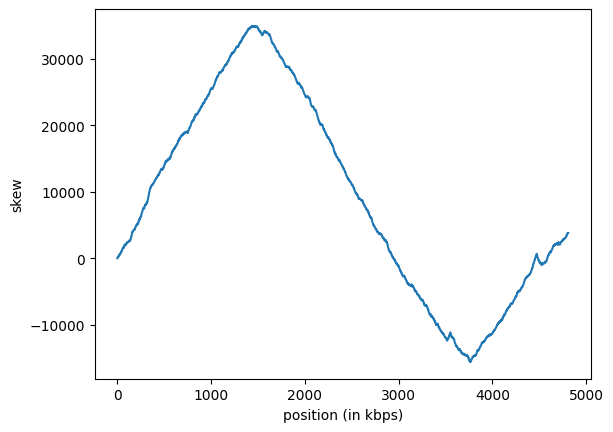

In [19]:
skews = skew(s_enterica_genome)
# resampling to avoid having to plot a couple hundred thousand values
resampled_skews = skews[::1000]
x_positions = range(len(resampled_skews)) 

plt.plot(x_positions, resampled_skews)
plt.ylabel("skew")
plt.xlabel("position (in kbps)")
plt.show()

It looks like *ori* might be somewhere around 3700-3800 kbps, and trying `minimum_skew()` confirms it.

In [20]:
print(minimum_skew(s_enterica_genome))

[3764856, 3764858]


Let's apply the same approach as we did above, with a window size of 500 bps, and starting at the minimum skew.

In [21]:
potential_ori = s_enterica_genome[3764856:3765356]
" ".join(frequent_words_with_mismatches_and_reverse_complements(potential_ori, 9, 1))

'CCCGGATCC GGATCCGGG CGGATCCGG CCGGATCCG GGATCCTGG CCAGGATCC'

I mean, we have a complementary pair and most of these are quite similar. But what if we widened the search area to 500 bps before the *ori* and 500 bps after?

In [22]:
print(3764856-500)
potential_ori = s_enterica_genome[3764356:3765356]
" ".join(frequent_words_with_mismatches_and_reverse_complements(potential_ori, 9, 1))

3764356


'TTATCCACA TGTGGATAA'

Wow, nice! This is the same *DnaA* box as in *E. coli*. I don't really know how you'd know to look for the correct *DnaA* box sequence if you were looking at bacteria that didn't belong in the same family (Enteriobacteriaceae). But this is neat. 

This concludes Week 2 content. In Week 3, the course turns toward randomized algorithms. 